In [1]:
from fgbuster import harmonic_ilc_alm,CMB
import healpy as hp
import pysm3
import pysm3.units as u
import sys
import curvedsky as cs
import cmb
import os
import numpy as np
from tqdm import tqdm
import sys
sys.path.append('../')
from utils import camb_clfile,cli
import mpi
import matplotlib.pyplot as plt
import pickle as pl
from database import surveys,noise

In [2]:
infolder = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/CMB_Lensed_Maps/CMB/'
dnside = 512
lmax = 3*dnside -1
maskpath = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/Masks/LB_Nside2048_fsky_0p8_binary.fits'
cl_lenf = '/global/cscratch1/sd/lonappan/S4BIRD/CAMB/BBSims_lensed_dls.dat'
cl_len = cmb.read_camb_cls(cl_lenf,ftype='lens',output='array')[:,:lmax+1]
mydir = '/project/projectdirs/litebird/simulations/maps/lensing_project_paper/S4BIRD/HILC_debug'
os.makedirs(mydir,exist_ok=True)

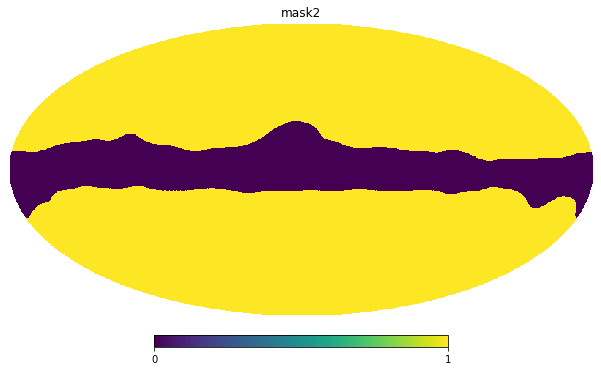

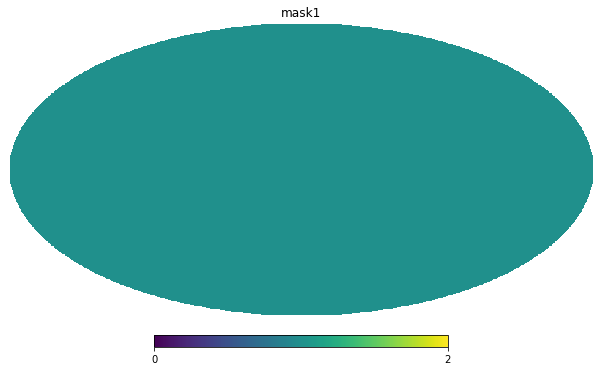

In [3]:
mask1 = np.ones(hp.nside2npix(dnside),dtype=int)
mask2 = hp.ud_grade(hp.read_map(maskpath),dnside)
hp.mollview(mask2,title='mask2')
hp.mollview(mask1,title='mask1')

In [4]:
class INST:
    def __init__(self,beam,frequency):
        self.Beam = beam
        self.fwhm = beam
        self.frequency = frequency
        
def get_cmb():
    idx = 0
    fname = os.path.join(infolder,f"cmb_sims_{idx:04d}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def get_fg(v):
    fname = os.path.join(fg_dir,f"{fg_str}_{int(v)}.fits")
    return hp.ud_grade(hp.read_map(fname,(0,1,2)),dnside)

def cmb_fg(v):
    fname = os.path.join(mydir,f'total_{int(v)}.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        maps = get_cmb() + get_fg(v)
        hp.write_map(fname,maps)
        return maps


def get_noise_spectra(depth_i,depth_p):
    t = np.ones(lmax+1)*(np.radians(depth_i/60)**2)
    e = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    b = np.ones(lmax+1)*(np.radians(depth_p/60)**2)
    return t,e,b

def get_noise_alm(depth_i,depth_p):
    t,e,b = get_noise_spectra(depth_i,depth_p)
    t = hp.synalm(t,lmax=lmax)
    e = hp.synalm(e,lmax=lmax)
    b = hp.synalm(b,lmax=lmax)
    return t,e,b


def get_noise_map1(v,depth_i,depth_p):
    fname = os.path.join(mydir,f'noise_{int(v)}_v1.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        t,e,b = get_noise_alm(depth_i,depth_p)
        maps =  hp.alm2map([t,e,b],nside=dnside)
        hp.write_map(fname,maps)
        return maps
def get_noise_map2(v,depth_i,depth_p):
    depth_i = np.array([depth_i])
    depth_p = np.array([depth_p])
    fname = os.path.join(mydir,f'noise_{int(v)}_v2.fits')
    if os.path.isfile(fname):
        return hp.read_map(fname,(0,1,2))
    else:
        pix_amin2 = 4. * np.pi / float(hp.nside2npix(dnside)) * (180. * 60. / np.pi) ** 2
        """sigma_pix_I/P is std of noise per pixel. It is an array of length
        equal to the number of input maps."""
        sigma_pix_I = np.sqrt(depth_i ** 2 / pix_amin2)
        sigma_pix_P = np.sqrt(depth_p ** 2 / pix_amin2)
        npix = hp.nside2npix(dnside)
        noise = np.random.randn(len(depth_i), 3, npix)
        noise[:, 0, :] *= sigma_pix_I[:, None]
        noise[:, 1, :] *= sigma_pix_P[:, None]
        noise[:, 2, :] *= sigma_pix_P[:, None]
        noise = noise[0]
        hp.write_map(fname,noise)
        return noise

def get_noise_map(v,depth_i,depth_p,which=2):
    if which == 1:
        return get_noise_map1(v,depth_i,depth_p)
    else:
        return get_noise_map2(v,depth_i,depth_p)


def get_exp_maps1(v,depth_i,depth_p,beam):
    fl = hp.gauss_beam(np.radians(beam/60),lmax=lmax, pol=True).T
    maps = hp.smoothing(cmb_fg(v),fwhm=np.radians(beam/60)) + get_noise_map(v,depth_i,depth_p)
    alms = hp.map2alm(maps)
    hp.almxfl(alms[0],cli(fl[0]),inplace=True)
    hp.almxfl(alms[1],cli(fl[1]),inplace=True)
    hp.almxfl(alms[2],cli(fl[2]),inplace=True)
    return alms

def get_exp_maps2(v,depth_i,depth_p,beam):
    fl = hp.gauss_beam(np.radians(beam/60),lmax=lmax, pol=True).T
    maps = hp.smoothing(cmb_fg(v),fwhm=np.radians(beam/60)) + get_noise_map(v,depth_i,depth_p)
    
    maps_masked = hp.ma(maps)
    maps_masked.mask = np.logical_not(mask2)
    maps_masked.filled()
    
    alms = hp.map2alm(maps_masked)
    hp.almxfl(alms[0],cli(fl[0]),inplace=True)
    hp.almxfl(alms[1],cli(fl[1]),inplace=True)
    hp.almxfl(alms[2],cli(fl[2]),inplace=True)
    return alms



def get_exp_arr(v,n_t,n_p,beam,which=1):
        arr = []
        for i in tqdm(range(len(v)),desc="Making map",unit='Freq'):
            if which == 1:
                arr.append(get_exp_maps1(v[i],n_t[i],n_p[i],beam[i]))
            else:
                arr.append(get_exp_maps2(v[i],n_t[i],n_p[i],beam[i]))
        return np.array(arr)

def apply_harmonic_W(W,  # (..., ell, comp, freq)
                      alms):  # (freq, ..., lm)
    lmax = hp.Alm.getlmax(alms.shape[-1])
    res = np.full((W.shape[-2],) + alms.shape[1:], np.nan, dtype=alms.dtype)
    start = 0
    for i in range(0, lmax+1):
        n_m = lmax + 1 - i
        res[..., start:start+n_m] = np.einsum('...lcf,f...l->c...l',
                                              W[..., i:, :, :],
                                              alms[..., start:start+n_m])
        start += n_m
    return res


In [5]:
sigma = 2.16
Tcmb  = 2.726e6
invn1 = mask1 * (np.radians(sigma/60)/Tcmb)**-2
invN1 = np.reshape(np.array((invn1,invn1)),(2,1,hp.nside2npix(dnside)))
invn2 = mask2 * (np.radians(sigma/60)/Tcmb)**-2
invN2 = np.reshape(np.array((invn2,invn2)),(2,1,hp.nside2npix(dnside)))
fg_dir = '/global/cscratch1/sd/lonappan/S4BIRD/FG'
fg_str = "s0d0"

In [6]:
table = surveys().get_table_dataframe("LITEBIRD_V1")
table = table[table.frequency > 0]
exp_freqs = np.array(table.frequency)
exp_beam = np.array(table.fwhm)
exp_nlev_p = np.array(table.depth_p)
exp_nlev_t = exp_nlev_p/np.sqrt(2)

In [7]:
instrument = INST(None,exp_freqs)
components = [CMB()]
bins = np.arange(1000) * 10

In [8]:
alms1= get_exp_arr(exp_freqs,exp_nlev_t,exp_nlev_p,exp_beam,which=1)

Making map: 100%|██████████| 15/15 [06:26<00:00, 25.79s/Freq]


In [9]:
alms2= get_exp_arr(exp_freqs,exp_nlev_t,exp_nlev_p,exp_beam,which=2)

Making map: 100%|██████████| 15/15 [06:23<00:00, 25.58s/Freq]


(4.940310795289416e-07, 100)

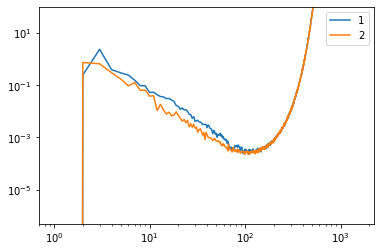

In [10]:
plt.loglog(hp.alm2cl(alms1[1][2]),label='1')
plt.loglog(hp.alm2cl(alms2[1][2])/.8,label='2')
plt.legend()
plt.ylim(None,100)

In [11]:
result1 = harmonic_ilc_alm(components, instrument,alms1,bins)

In [12]:
result2 = harmonic_ilc_alm(components, instrument,alms2,bins)

In [13]:
TEB1 = [result1.s[0,0],result1.s[0,1],result1.s[0,2]]
TEB2 = [result2.s[0,0],result2.s[0,1],result2.s[0,2]]

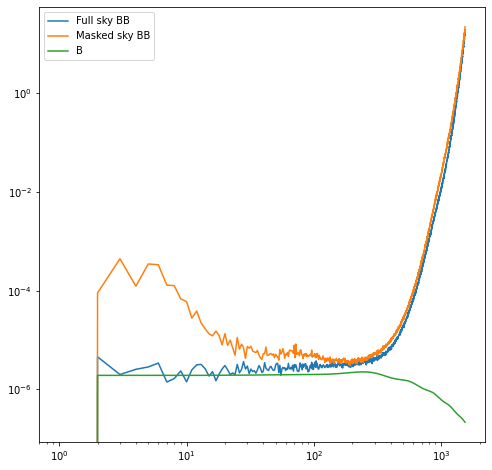

In [14]:
plt.figure(figsize=(8,8))
plt.loglog(hp.alm2cl(TEB1[2]),label='Full sky BB')
plt.loglog(hp.alm2cl(TEB2[2]),label='Masked sky BB')
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.legend()

In [15]:
w1 = result1.W
w2 = result2.W

In [16]:
noise_alm_arr = []
for v,n_t,n_p in zip(exp_freqs,exp_nlev_t,exp_nlev_p):
    noise_alm_arr.append(hp.map2alm(get_noise_map(v,n_t,n_p)))

In [17]:
nlm1 = apply_harmonic_W(w1,np.array(noise_alm_arr))[0]
nlm2 = apply_harmonic_W(w2,np.array(noise_alm_arr))[0]

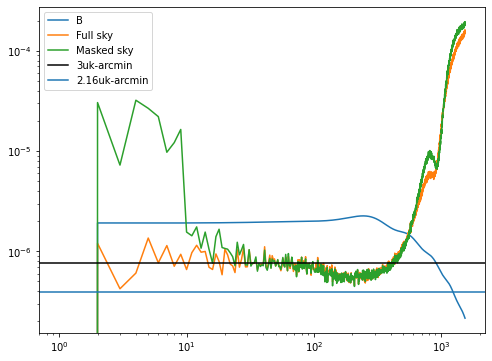

In [18]:
plt.figure(figsize=(8,6))
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.loglog(hp.alm2cl(nlm1[2]),label='Full sky')
plt.loglog(hp.alm2cl(nlm2[2]),label='Masked sky')
plt.axhline(np.radians(3/60)**2,c='k',label='3uk-arcmin')
plt.axhline(np.radians(2.16/60)**2,label='2.16uk-arcmin')
plt.legend()

In [19]:
Nl_P = []
B_P = []
for b,n in zip(exp_beam,np.radians(exp_nlev_p/60)**2):
    B_P.append(hp.gauss_beam(np.radians(b/60),lmax=lmax))
    Nl_P.append(np.ones(lmax+1)*n)
Nl_P = np.array(Nl_P)
B_P = np.array(B_P)

In [20]:
w_bb1 = result1.W[2]
nl_bb1 = np.zeros(lmax+1)
bl_bb1 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_bb1[i] = np.dot(Nl_P[:, i], w_bb1[i][0]**2)
for i in range(lmax+1):
    bl_bb1[i] = np.dot(B_P[:, i], w_bb1[i][0])

w_bb2 = result2.W[2]
nl_bb2 = np.zeros(lmax+1)
bl_bb2 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_bb2[i] = np.dot(Nl_P[:, i], w_bb2[i][0]**2)
for i in range(lmax+1):
    bl_bb2[i] = np.dot(B_P[:, i], w_bb2[i][0])

    

w_ee1 = result1.W[1]
nl_ee1 = np.zeros(lmax+1)
bl_ee1 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_ee1[i] = np.dot(Nl_P[:, i], w_ee1[i][0]**2)
for i in range(lmax+1):
    bl_ee1[i] = np.dot(B_P[:, i], w_ee1[i][0])


w_ee2 = result2.W[1]
nl_ee2 = np.zeros(lmax+1)
bl_ee2 = np.zeros(lmax+1)
for i in range(lmax+1):
    nl_ee2[i] = np.dot(Nl_P[:, i], w_ee2[i][0]**2)
for i in range(lmax+1):
    bl_ee2[i] = np.dot(B_P[:, i], w_ee2[i][0])

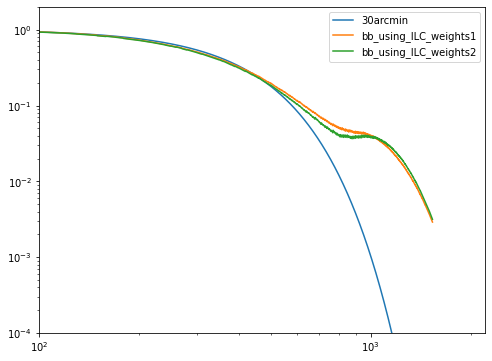

In [21]:
plt.figure(figsize=(8,6))
plt.loglog(hp.gauss_beam(np.radians(30/60),lmax=lmax),label='30arcmin')
plt.loglog(bl_bb1,label='bb_using_ILC_weights1')
plt.loglog(bl_bb2,label='bb_using_ILC_weights2')
plt.ylim(1e-4,2)
plt.xlim(100,None)
plt.legend()

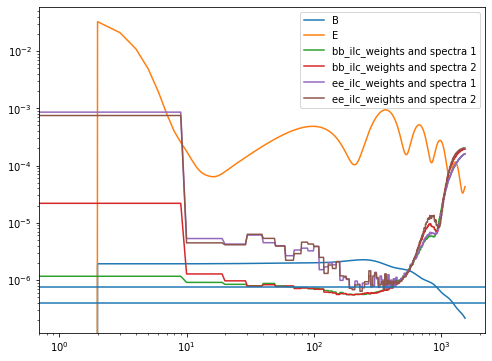

In [45]:
plt.figure(figsize=(8,6))
plt.loglog(cl_len[2,:]*Tcmb**2,label='B')
plt.loglog(cl_len[1,:]*Tcmb**2,label='E')
#plt.loglog(hp.alm2cl(nlm1[2]),label='bb_ilc_weights and maps 1')
#plt.loglog(hp.alm2cl(nlm2[2]),label='bb_ilc_weights and maps 2')
plt.loglog(nl_bb1,label='bb_ilc_weights and spectra 1')
plt.loglog(nl_bb2,label='bb_ilc_weights and spectra 2')
plt.loglog(nl_ee1,label='ee_ilc_weights and spectra 1')
plt.loglog(nl_ee2,label='ee_ilc_weights and spectra 2')
plt.axhline(np.radians(3/60)**2)
plt.axhline(np.radians(2.16/60)**2)
plt.legend()

In [47]:
TQU1 = hp.smoothing(hp.alm2map(TEB1,dnside),np.radians(30/60))
TQU2 = hp.smoothing(hp.alm2map(TEB2,dnside),np.radians(30/60))

In [48]:
QU1 = np.reshape(np.array((TQU1[1]*mask2,TQU1[2]*mask2)),(2,1,hp.nside2npix(dnside)))/Tcmb
QU2 = np.reshape(np.array((TQU2[1]*mask2,TQU2[2]*mask2)),(2,1,hp.nside2npix(dnside)))/Tcmb

In [49]:
Bl = np.reshape(hp.gauss_beam(np.radians(30/60),lmax=lmax),(1,lmax+1))

In [50]:
E_2p16_1,B_2p16_1 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN2,QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')


In [51]:
E_2p16_2,B_2p16_2 =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,invN2,QU2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [52]:
wofg_bl = hp.gauss_beam(np.radians(30/60),lmax=lmax)
wofg_Bl = np.reshape(wofg_bl,(1,lmax+1))

ntt = np.ones(lmax+1)  * np.radians(1.5/60)**2
npp = np.ones(lmax+1)  * np.radians(2.16/60)**2

wofg_N = hp.synfast([ntt,npp,npp,npp*0],dnside)

In [29]:
maps = wofg_N + hp.smoothing(get_cmb(),fwhm=np.radians(30/60))
alms = hp.map2alm(maps)
hp.almxfl(alms[0],cli(wofg_bl),inplace=True)
hp.almxfl(alms[1],cli(wofg_bl),inplace=True)
hp.almxfl(alms[2],cli(wofg_bl),inplace=True)
hp.almxfl(alms[0],wofg_bl,inplace=True)
hp.almxfl(alms[1],wofg_bl,inplace=True)
hp.almxfl(alms[2],wofg_bl,inplace=True)

array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -5.17985469e-04+0.00000000e+00j, ...,
        3.32706046e-11-1.81262128e-11j,  5.02428386e-11-4.48380249e-11j,
        1.73384024e-12+5.61103325e-12j])

In [30]:
TQU_wofg = hp.alm2map(alms,dnside)

In [31]:
QU_wofg = np.reshape(np.array((TQU_wofg[1],TQU_wofg[2])),(2,1,hp.nside2npix(dnside)))/Tcmb

In [32]:
E_wofg,B_wofg =cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],wofg_Bl,invN1,QU_wofg,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

/tmp/ipykernel_62485/1239605263.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


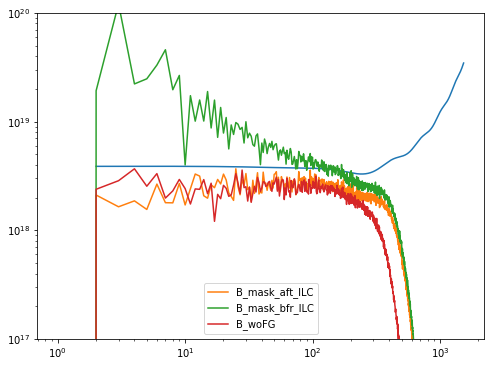

In [59]:
plt.figure(figsize=(8,6))
plt.loglog(1/cl_len[2,:])
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_1),label='B_mask_aft_ILC')
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_2),label='B_mask_bfr_ILC')
plt.loglog(cs.utils.alm2cl(lmax,B_wofg),label='B_woFG')
plt.ylim(1e17,1e20)
plt.legend()

In [34]:
NL1 = np.reshape(np.array((cli(nl_ee1[:lmax+1]/Tcmb**2),cli(nl_bb1[:lmax+1]/Tcmb**2))),(2,1,lmax+1))
NL2 = np.reshape(np.array((cli(nl_ee2[:lmax+1]/Tcmb**2),cli(nl_bb2[:lmax+1]/Tcmb**2))),(2,1,lmax+1))

In [54]:
E_2p16_1_nl, B_2p16_1_nl = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,
                                                  np.reshape(np.array((mask2,mask2)),(2,1,hp.nside2npix(dnside))),
                                                  QU1,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt',inl=NL1)

In [55]:
E_2p16_2_nl, B_2p16_2_nl = cs.cninv.cnfilter_freq(2,1,dnside,lmax,cl_len[1:3,:],Bl,
                                                  np.reshape(np.array((mask2,mask2)),(2,1,hp.nside2npix(dnside))),
                                                  QU2,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt',inl=NL2)

/tmp/ipykernel_62485/3915842947.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/cl_len[2,:])


(1e+17, 1e+20)

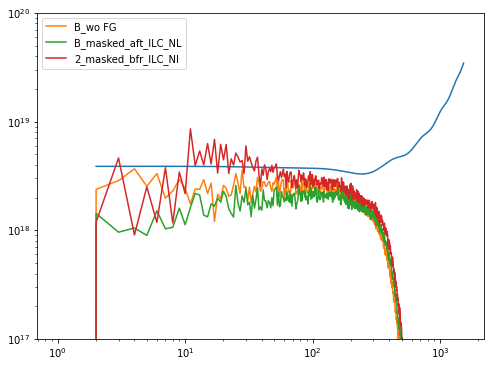

In [61]:
plt.figure(figsize=(8,6))
plt.loglog(1/cl_len[2,:])

plt.loglog(cs.utils.alm2cl(lmax,B_wofg),label='B_wo FG')
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_1_nl),label='B_masked_aft_ILC_NL')
plt.loglog(cs.utils.alm2cl(lmax,B_2p16_2_nl),label='2_masked_bfr_ILC_Nl')
plt.legend()
plt.ylim(1e17,1e20)

/tmp/ipykernel_62485/3824070207.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B_2p16_2_nl)/cs.utils.alm2cl(lmax,B_wofg))
/tmp/ipykernel_62485/3824070207.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(cs.utils.alm2cl(lmax,B_2p16_2)/cs.utils.alm2cl(lmax,B_wofg))


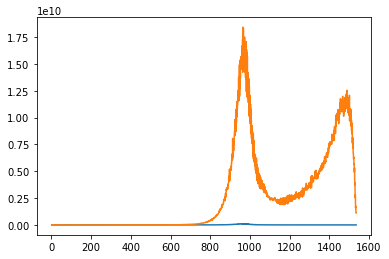

In [42]:
plt.plot(cs.utils.alm2cl(lmax,B_2p16_2_nl)/cs.utils.alm2cl(lmax,B_wofg))
plt.plot(cs.utils.alm2cl(lmax,B_2p16_2)/cs.utils.alm2cl(lmax,B_wofg))


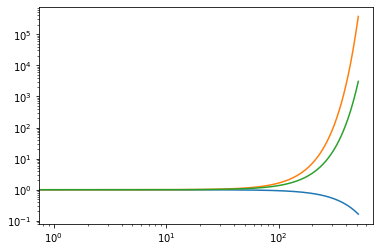

In [39]:
plt.loglog(hp.gauss_beam(np.radians(30/60)))
plt.loglog(1/hp.gauss_beam(np.radians(80/60)))
plt.loglog((1/hp.gauss_beam(np.radians(70/60))) * hp.gauss_beam(np.radians(30/60)))